# Analyzing the Correlation of Specific SNPs with BMI and Cardiovascular Diseases

## Imports

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import streamlit as st
import shap
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

## Data Preprocessing

In [40]:
# reading the data into a df + getting an initial look
df = pd.read_csv('patient_data.csv')

df.head()

,rs1047763,rs9282541,rs3827760,rs4988235,rs1801133,rs9374842,BMI,CardiovascularDisease
0,0,0,0,0,0,0,28.607859,0
1,0,0,1,1,0,0,26.651948,0
2,1,1,1,0,0,1,31.885502,0
3,0,0,1,0,0,0,29.353686,0
4,1,1,0,0,0,0,33.630251,0


In [41]:
# summary statistics
df.describe()

,rs1047763,rs9282541,rs3827760,rs4988235,rs1801133,rs9374842,BMI,CardiovascularDisease
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.433333,0.326667,0.490000,0.316667,0.286667,0.276667,28.899291,0.113333
std,0.496364,0.469778,0.500735,0.465953,0.452960,0.448098,5.171930,0.317529
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.798057,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.292649,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.185791,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32.131210,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,44.188743,1.000000


In [42]:
df.columns

Index(['rs1047763', 'rs9282541', 'rs3827760', 'rs4988235', 'rs1801133',
       'rs9374842', 'BMI', 'CardiovascularDisease'],
      dtype='object')

In [43]:
#checking for null values
df.isna().sum()

rs1047763                0
rs9282541                0
rs3827760                0
rs4988235                0
rs1801133                0
rs9374842                0
BMI                      0
CardiovascularDisease    0
dtype: int64

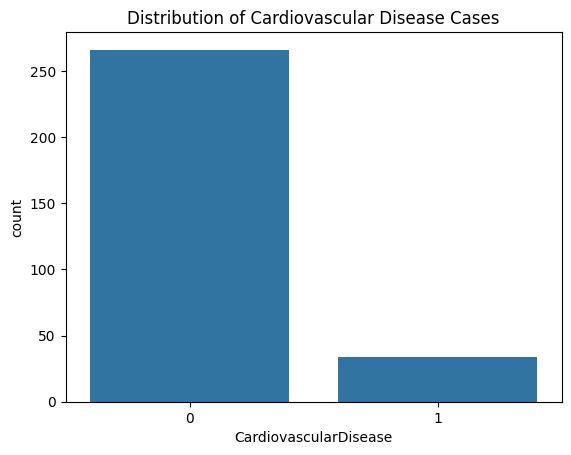

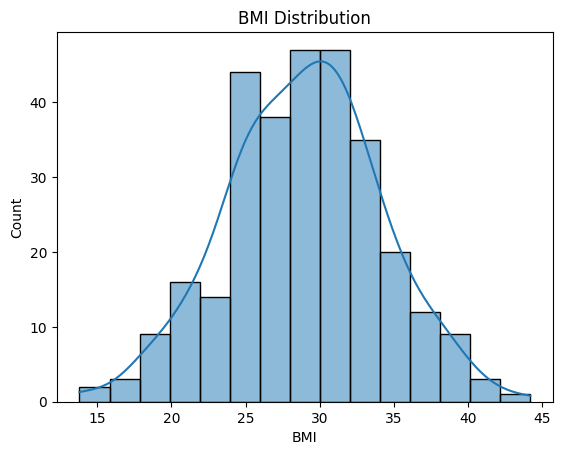

In [44]:
# Count plot for cardiovascular disease outcome
sns.countplot(x='CardiovascularDisease', data=df)
plt.title('Distribution of Cardiovascular Disease Cases')
plt.show()

# Histogram for BMI
sns.histplot(df['BMI'], kde=True)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.show()



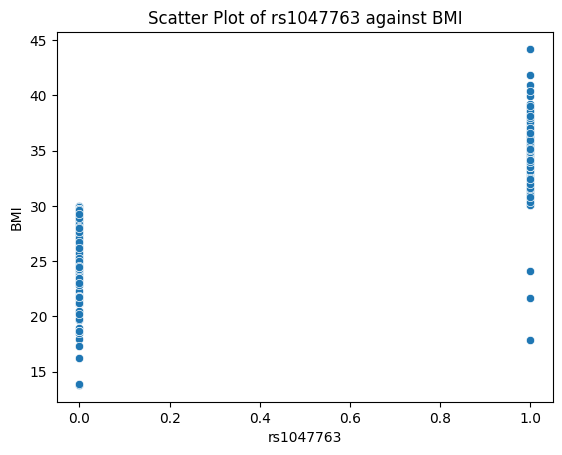

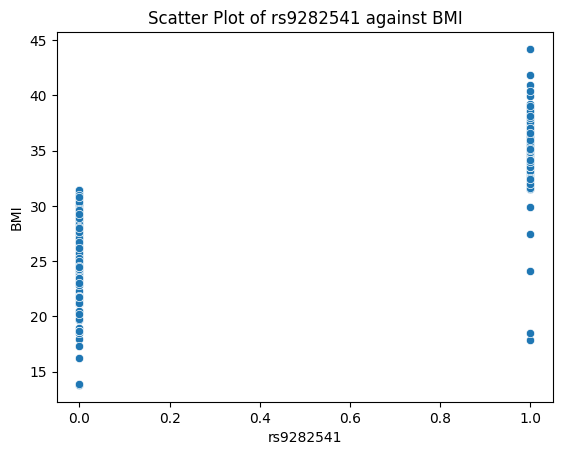

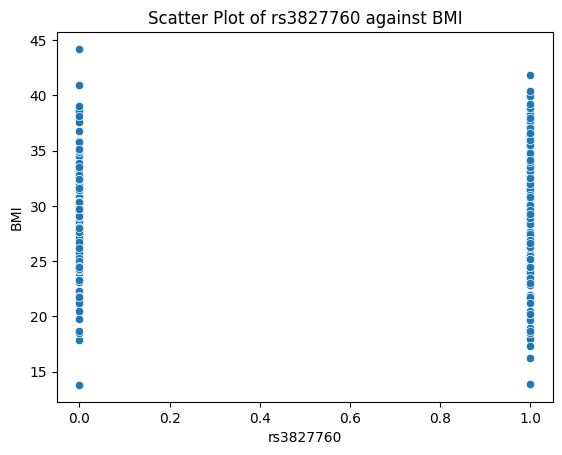

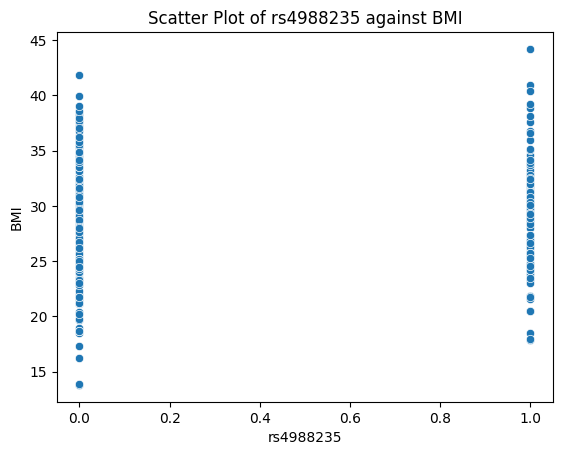

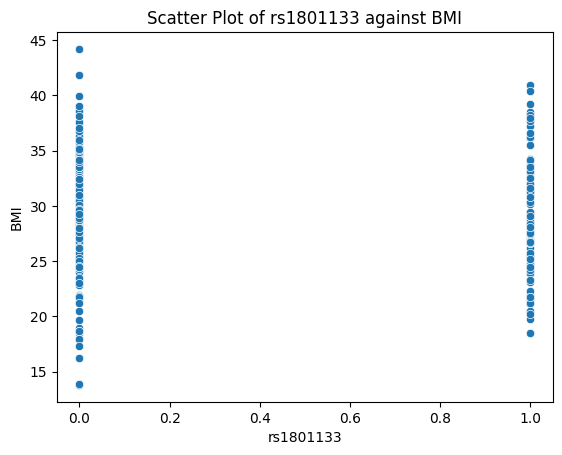

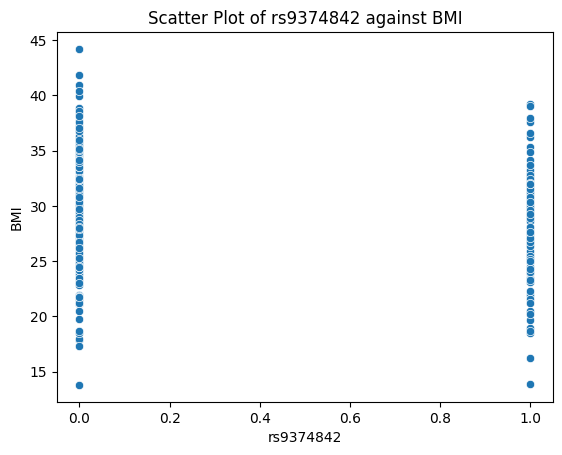

In [45]:
# Scatter plots for each SNP against BMI
for snp in ['rs1047763', 'rs9282541', 'rs3827760', 'rs4988235', 'rs1801133',
       'rs9374842']:  # Replace with your actual SNP column names
    sns.scatterplot(x=df[snp], y=df['BMI'])
    plt.title(f'Scatter Plot of {snp} against BMI')
    plt.xlabel(snp)
    plt.ylabel('BMI')
    plt.show()


### Correlation SNPs and BMI

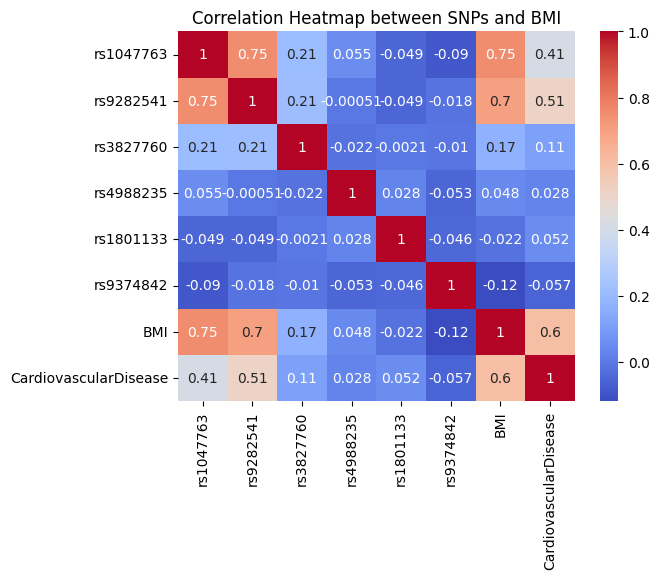

In [46]:
# Calculate correlations between SNPs and BMI
correlation_matrix = df[['rs1047763', 'rs9282541', 'rs3827760', 'rs4988235', 'rs1801133', 'rs9374842', 'BMI', 'CardiovascularDisease']].corr()  # Replace with your actual SNP column names

# Display the correlation coefficients between SNPs and BMI
# print(correlation_matrix['BMI'].drop('BMI'))  # Drop the BMI-BMI correlation

# Visualize the correlations using a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap between SNPs and BMI')
plt.show()


From this analysis, we can conclude that 'rs1047763' and 'rs9282541' are significantly correlated with the BMI (and with each other!).

### Train-Test-Split
As the df is imported and no null/NA values have been found, we now perform the train-test-split.

In [47]:
# Data preprocessing
X = df.drop('CardiovascularDisease', axis=1)
y = df['CardiovascularDisease']
X['BMI'] = StandardScaler().fit_transform(X['BMI'].values.reshape(-1, 1))

# Initialize a scaler
scaler = StandardScaler()

# Scale BMI column (assuming it's the last column before the target)
X_scaled = X.copy()
X_scaled['BMI'] = scaler.fit_transform(X[['BMI']])  # Fit and transform scaler on BMI

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)


## Logistic Regression Model on the Data including BMI in X with Cardiovascular Disease as Target

In [48]:
# Model initialization and training
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Predictions

In [49]:
# Predictions
predictions = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))
print('ROC AUC Score:', roc_auc_score(y_test, predictions))

Accuracy: 0.9833333333333333
ROC AUC Score: 0.9375


In [50]:
#first look at how the model is performing
print(classification_report(y_test, predictions, target_names=['Absent', 'Present']))

              precision    recall  f1-score   support

      Absent       0.98      1.00      0.99        52
     Present       1.00      0.88      0.93         8

    accuracy                           0.98        60
   macro avg       0.99      0.94      0.96        60
weighted avg       0.98      0.98      0.98        60



In the next step, I am computing the predicted labels with my model for the whole df, so I can identify cases in which the system made misclassifications.

In [51]:
# computing the predicted y for the whole df 
y_pred = model.predict(X)

#adding predicted y to the whole df
df_with_predictions = df.copy()
df_with_predictions['predictions'] = y_pred

Plotting the confusion matrix so we can see how the model is performing.

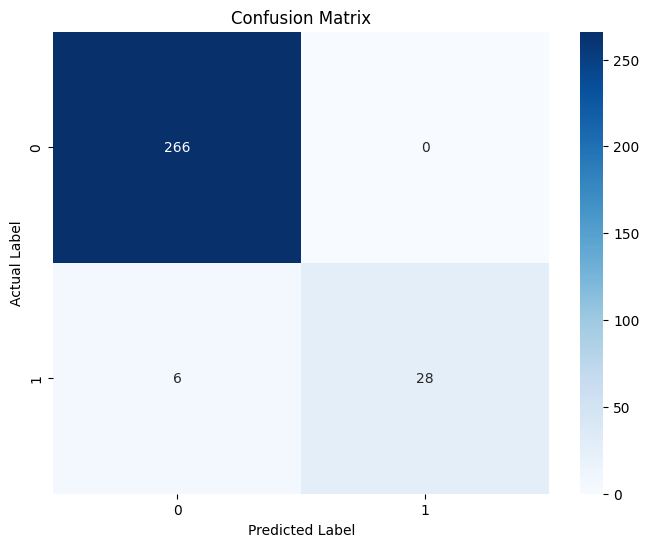

In [52]:
# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Misclassifications

In [53]:
misclassifications = df_with_predictions[df_with_predictions['CardiovascularDisease'] != df_with_predictions['predictions']]
correct_classifications = df_with_predictions[df_with_predictions['CardiovascularDisease'] == df_with_predictions['predictions']]
X_misclassified = misclassifications.drop(['CardiovascularDisease','predictions'], axis=1)
y_misclassified = misclassifications['CardiovascularDisease']

In [54]:
misclassifications

,rs1047763,rs9282541,rs3827760,rs4988235,rs1801133,rs9374842,BMI,CardiovascularDisease,predictions
25,1,1,0,0,0,0,35.168850,1,0
51,1,1,1,0,0,0,35.350751,1,0
64,1,1,1,0,0,1,35.296228,1,0
133,1,1,1,0,1,0,35.519422,1,0
256,1,1,0,1,0,0,35.021741,1,0
282,1,1,0,1,0,0,35.098015,1,0


Here we can see that the BMI of these misclassification is very high, higher than the 75th percentile (in fact, in the 89% percentile!).

In [55]:
df.quantile(0.89)

rs1047763                 1.000000
rs9282541                 1.000000
rs3827760                 1.000000
rs4988235                 1.000000
rs1801133                 1.000000
rs9374842                 1.000000
BMI                      35.030131
CardiovascularDisease     1.000000
Name: 0.89, dtype: float64

## Analysis on the Dataframe including the predictions of the initial LogisticRegression Model

In [56]:
# Add 'Classification' column
df_with_predictions['Classification'] = df_with_predictions['CardiovascularDisease'] == df_with_predictions['predictions']

# The 'Classification' column will contain boolean values: True or False
# If you want to have string representations, you can map the boolean values to strings
df_with_predictions['Classification'] = df_with_predictions['Classification'].map({True: 'True', False: 'False'})


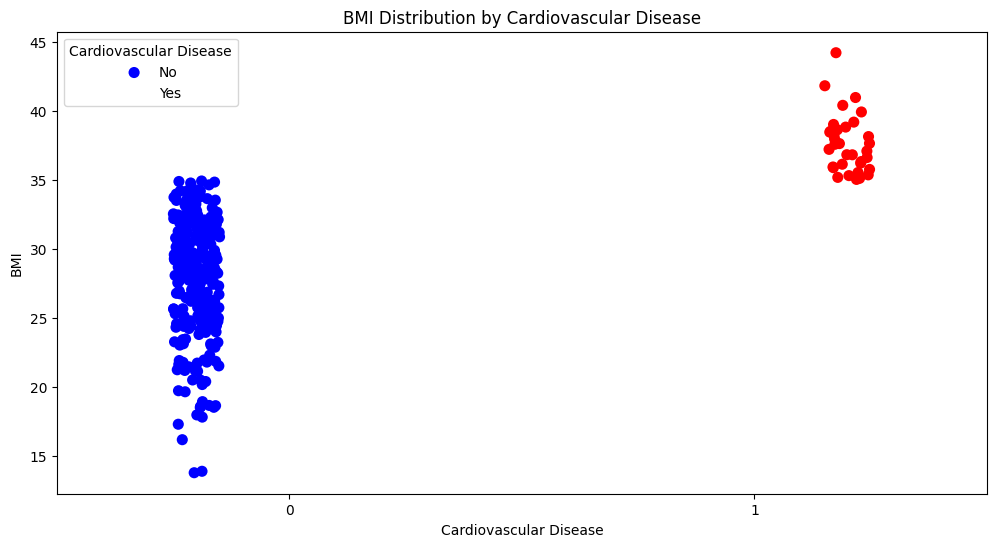

In [57]:
plt.figure(figsize=(12, 6))
sns.stripplot(data=df_with_predictions, x='CardiovascularDisease', y='BMI', hue='CardiovascularDisease', palette=['blue', 'red'], jitter=True, dodge=True, size=8)
plt.title('BMI Distribution by Cardiovascular Disease')
plt.xlabel('Cardiovascular Disease')
plt.ylabel('BMI')
plt.legend(title='Cardiovascular Disease', labels=['No', 'Yes'])
plt.show()

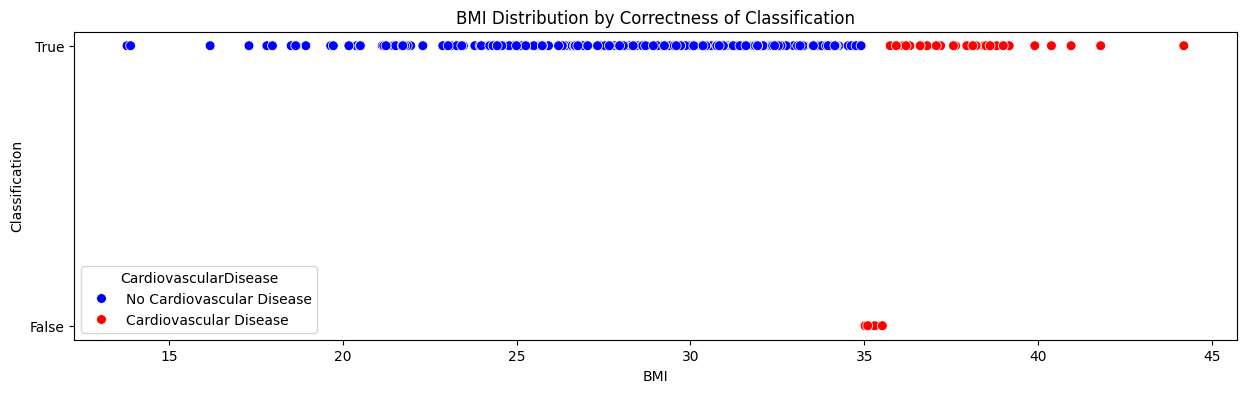

In [58]:
# Now plot using seaborn
plt.figure(figsize=(15, 4))
sns.scatterplot(data=df_with_predictions, x='BMI', y='Classification', hue='CardiovascularDisease', palette=['blue', 'red'], s=50)

# Add a legend with more descriptive labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['No Cardiovascular Disease', 'Cardiovascular Disease'], title='CardiovascularDisease')

# Adding a title
plt.title('BMI Distribution by Correctness of Classification')

# Display the plot
plt.show()

### SHAP Summary Plot

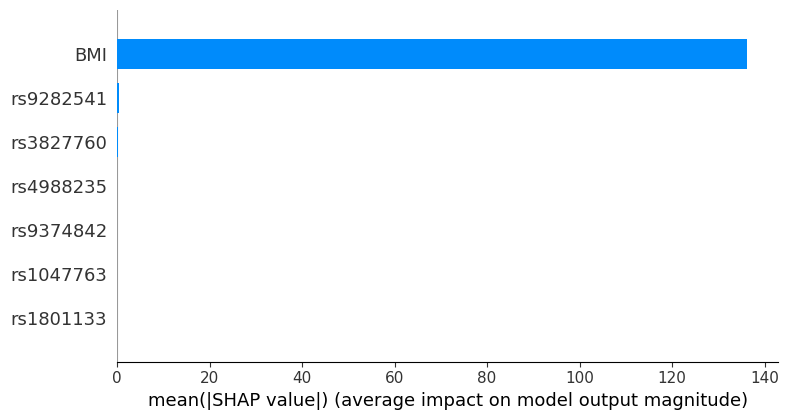

In [59]:

# SHAP Summary Plot
# Logistic Regression requires a linear explainer
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_misclassified)

# Summary plot for all features
shap.summary_plot(shap_values, X_misclassified, plot_type="bar")
plt.show()

From this analysis, we can see that the model misclassifies the instances relying on the BMI. 

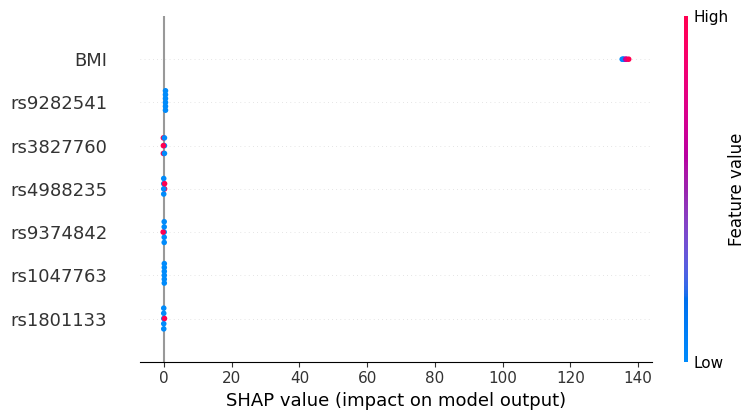

In [60]:
# Detailed SHAP summary plot (useful for insights on feature impact)
shap.summary_plot(shap_values, X_misclassified)
plt.show()

## Evaluate Algorithm Performance

### Permutation Feature Importance

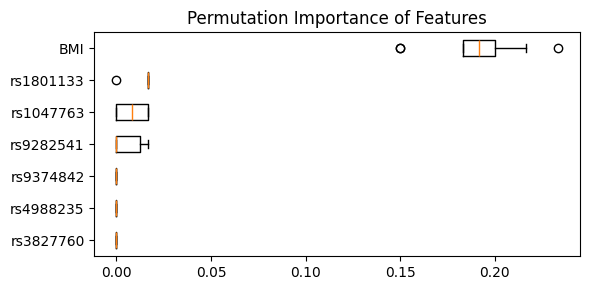

In [63]:
# Feature Permutation Importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

# Plotting the feature importances
plt.figure(figsize=(6, 3))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()

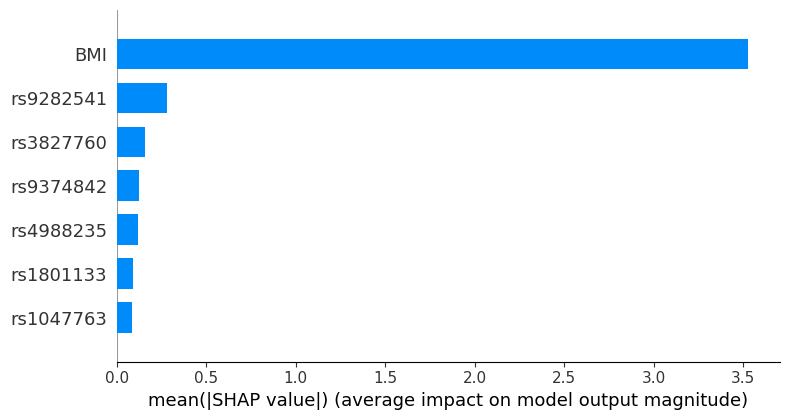

In [64]:

# SHAP Summary Plot
# Logistic Regression requires a linear explainer
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# Summary plot for all features
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

Accuracy: 0.98
Precision: 1.00
Recall: 0.88
F1 Score: 0.93
ROC AUC: 1.00


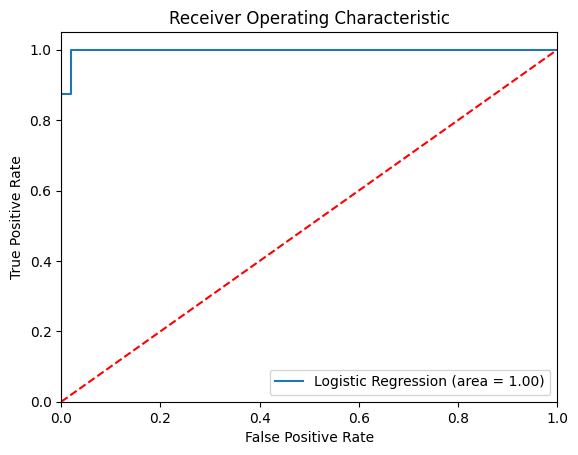

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming predictions and y_test are already defined from your model testing phase
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Comparision with RandomForest

Random Forest Accuracy: 1.00
Random Forest Precision: 1.00
Random Forest Recall: 1.00
Random Forest F1 Score: 1.00
Random Forest ROC AUC: 1.00


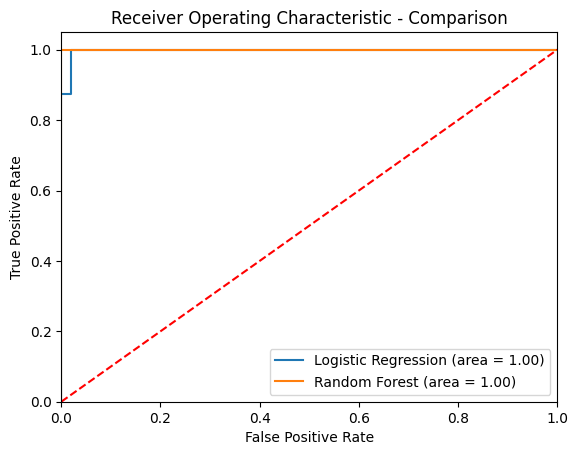

In [66]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

# Predict using Random Forest
rf_predictions = rf_model.predict(X_test)
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Metrics
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)

print(f'Random Forest Accuracy: {rf_accuracy:.2f}')
print(f'Random Forest Precision: {rf_precision:.2f}')
print(f'Random Forest Recall: {rf_recall:.2f}')
print(f'Random Forest F1 Score: {rf_f1:.2f}')
print(f'Random Forest ROC AUC: {rf_roc_auc:.2f}')

# Comparing ROC Curves
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Comparison')
plt.legend(loc="lower right")
plt.show()


In [67]:
# Initialize the classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation
scores = cross_val_score(rf, X, y, cv=5)  # 5-fold cross-validation

# Print the accuracy for each fold
print("Accuracy for each fold:", scores)

# Print average accuracy
print("Average accuracy:", scores.mean())

Accuracy for each fold: [1.         1.         1.         1.         0.98333333]
Average accuracy: 0.9966666666666667


## Support Vector Machines 

In [68]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Creating and training the SVM model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9833333333333333


In [69]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Assuming X contains your features (including BMI) and y contains your target variable (Cardiovascular Disease)
X = df_with_predictions[['BMI']]
y = df_with_predictions['CardiovascularDisease']

# Creating the SVM model
svm_model = SVC(kernel='linear', C=1.0)

# Performing 5-fold cross-validation
cv_scores = cross_val_score(svm_model, X, y, cv=5)

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
print("Mean accuracy:", cv_scores.mean())


Cross-validation scores: [1.         1.         0.98333333 1.         0.96666667]
Mean accuracy: 0.99


# Model to predict 

# 

# Association between Selected SNPs and Cardiovascular Diseases: Model without BMI

In [70]:
df_without_BMI = df.drop('BMI', axis=1)
df_without_BMI.head(10)

,rs1047763,rs9282541,rs3827760,rs4988235,rs1801133,rs9374842,CardiovascularDisease
0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0
2,1,1,1,0,0,1,0
3,0,0,1,0,0,0,0
4,1,1,0,0,0,0,0
5,0,0,0,0,0,0,0
6,1,0,1,0,0,0,0
7,1,1,1,1,0,0,1
8,0,0,0,0,0,1,0
9,0,0,0,0,1,1,0


# Inner and Outer Cross Validation

In [71]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming df is your DataFrame containing the features and target
# X should contain your features and y should contain the target variable
X = X_without_BMI
y = y_without_BMI

# Split data into train and test sets for outer cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# Outer cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    # Inner cross-validation for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Hyperparameter tuning using GridSearchCV
    param_grid = {}  # Add hyperparameters grid for each model
    if model_name == 'Logistic Regression':
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    elif model_name == 'Random Forest':
        param_grid = {'n_estimators': [50, 100, 200]}
    elif model_name == 'SVM':
        param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001]}
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Evaluate model performance using outer cross-validation
    scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=outer_cv)
    print(f'{model_name}:')
    print(f'  Best Parameters: {grid_search.best_params_}')
    print(f'  Mean Cross-Validation Accuracy: {np.mean(scores):.8f}')

    # Fit the best model on the entire training set and evaluate on the test set
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'  Test Accuracy: {test_accuracy:.8f}')
    print()


Logistic Regression:
  Best Parameters: {'C': 0.001}
  Mean Cross-Validation Accuracy: 0.88333333
  Test Accuracy: 0.90000000

Random Forest:
  Best Parameters: {'n_estimators': 100}
  Mean Cross-Validation Accuracy: 0.89583333
  Test Accuracy: 0.90000000

SVM:
  Best Parameters: {'C': 0.1, 'gamma': 0.1}
  Mean Cross-Validation Accuracy: 0.88333333
  Test Accuracy: 0.90000000



Because Random Forest has the highest accuracy, we train a Random Forest Classifier.

In [72]:
# Data preprocessing
X_without_BMI = df.drop(['CardiovascularDisease', 'BMI'], axis=1)
y_without_BMI = df['CardiovascularDisease']


# Splitting the dataset into the Training set and Test set
X_train_noBMI, X_test_noBMI, y_train_noBMI, y_test_noBMI = train_test_split(X_without_BMI, y_without_BMI, test_size=0.2, random_state=0)

In [73]:
# Training a model (using RandomForest as an example)
model_rf_no_bmi = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_no_bmi.fit(X_train_noBMI, y_train_noBMI)


RandomForestClassifier(random_state=42)

In [77]:
# predictions for test set
test_predictions_noBMI = model_rf_no_bmi.predict(X_test_noBMI)


#Calculating accuracy
accuracy_test = accuracy_score(y_test_noBMI, test_predictions_noBMI)

print(f"Test accuracy: {accuracy_test}")
print(classification_report(y_test_noBMI, test_predictions_noBMI, target_names=['Absent', 'Present']))

Test accuracy: 0.9
              precision    recall  f1-score   support

      Absent       0.93      0.96      0.94        52
     Present       0.67      0.50      0.57         8

    accuracy                           0.90        60
   macro avg       0.80      0.73      0.76        60
weighted avg       0.89      0.90      0.89        60



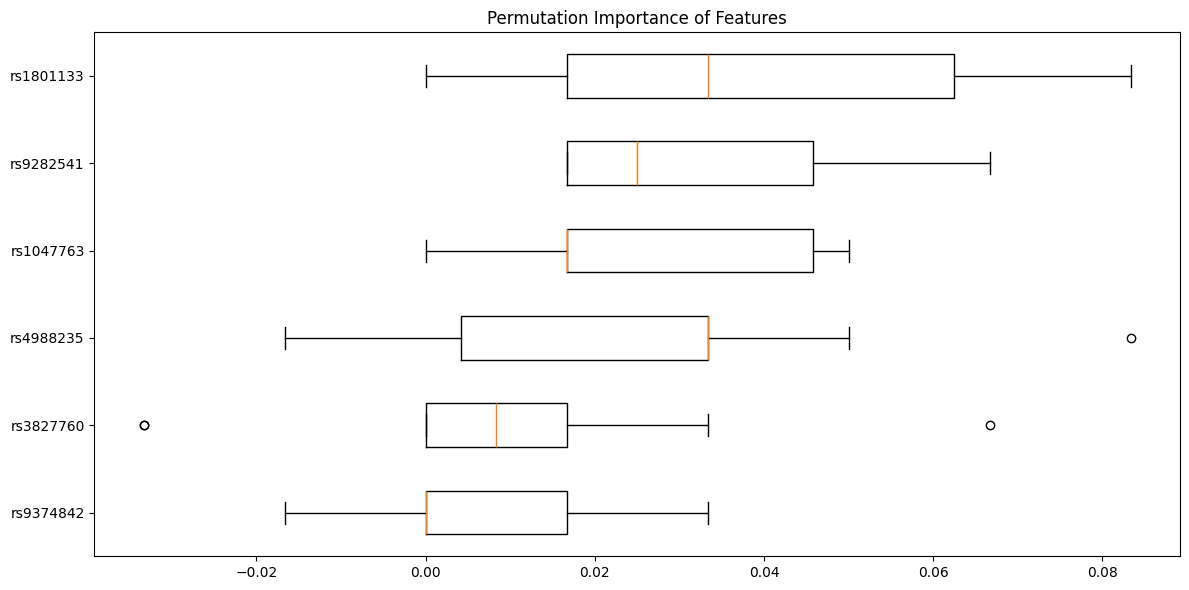

In [74]:
result_rf_no_bmi = permutation_importance(model_rf_no_bmi, X_test_noBMI, y_test_noBMI, n_repeats=10, random_state=42)
sorted_idx_no_bmi = result_rf_no_bmi.importances_mean.argsort()

plt.figure(figsize=(12, 6))
plt.boxplot(result_rf_no_bmi.importances[sorted_idx_no_bmi].T, vert=False, labels=X_test_noBMI.columns[sorted_idx_no_bmi])
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()

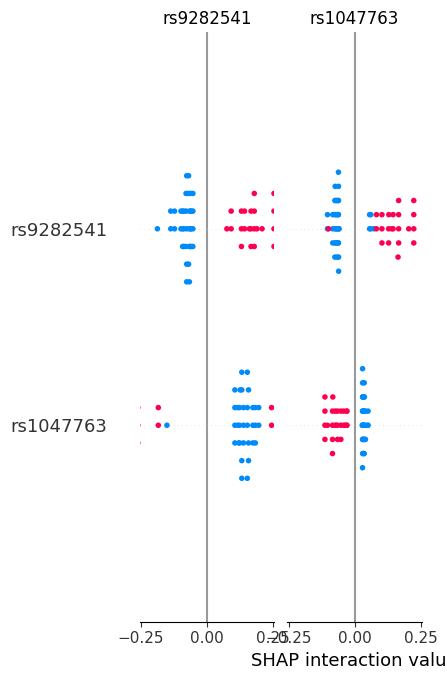

In [75]:
explainer_rf_no_bmi = shap.TreeExplainer(model_rf_no_bmi)
shap_values_rf_no_bmi = explainer_rf_no_bmi.shap_values(X_test_noBMI)

# Summary plot for all features
shap.summary_plot(shap_values_rf_no_bmi, X_test_noBMI, plot_type="bar")
plt.show()

## Streamlit Output
This is where the base is laid for the Streamlit application. The Random Forest Model is written into a pickle file, which will then be used in the app.py script that runs the Streamlit application

In [78]:
with open('model_rf.pkl', 'wb') as file:
    pickle.dump(model_rf_no_bmi, file)

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In the next step, I make sure whether the loaded model from the pickle file is working as intended. 

In [87]:
# Load the model from the provided pickle file
with open('model_rf.pkl', 'rb') as file:
    model_rf = pickle.load(file)

# Create a DataFrame with the same structure the model expects
dummy_input = pd.DataFrame({
    'rs1047763': [1],
    'rs9282541': [1],
    'rs3827760': [1],
    'rs4988235': [0],
    'rs1801133': [0],
    'rs9374842': [0]
})

# Make a prediction with the dummy input
probability = model_rf.predict_proba(dummy_input)[0][1]
probability



0.2705942274976271